# 뉴스 그룹 분류 경진대회 베이스라인

이번 대회는 영어 뉴스 데이터를 통해 뉴스 그룹을 분류하는 대회입니다.

스포츠, 사회, 과학, 정치, 종교 등 20개의 카테고리의 토픽을 분류하는 대회입니다.

대회를 시작하기 앞서 어떤 데이터가 주어졌고 어떤 방식으로 활용할 수 있을지

데이터를 분석하고 시각화하며 인사이트를 얻어내는 작업이 필요합니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Colab Notebooks/NLP/2022-NLP"
#!unzip "뉴스그룹분류경진대회"

/content/drive/MyDrive/Colab Notebooks/NLP/2022-NLP


# 패키지 설치

EDA를 시작하기에 앞서 필요한 패키지들을 설치합니다.




In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# 데이터 불러오기

In [5]:
#csv 형식의 training 데이터를 로드합니다.
train = pd.read_csv('./train.csv')

#데이터 살펴보기 위해 데이터 최상단의 5줄을 표시합니다.
train.head() 

,id,text,target
0,0,"\nThey were, and even if Washington might cons...",10
1,1,"We run ""SpaceNews & Views"" on our STAREACH BBS...",14
2,2,\n\n\nNot to worry. The Masons have been demo...,19
3,3,"Only Brendan McKay, or maybe ARF, would come t...",17
4,4,Help: I am running some sample problems from O...,5


In [6]:
temp = train.target.unique() # 라벨의 고유값 확인
np.sort(temp)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

데이터를 살펴보니 text에서 영어로 된 문자열이 주를 이루며, 각 뉴스 text는 0~19까지 스무가지로 그룹이 라벨링 되어있습니다.



# 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [7]:
# 결측치 존재 여부를 확인해주는 함수
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


결측치가 없는 깔끔한 데이터셋입니다!

결측치 처리는 넘어가도록 하겠습니다.

# 기초 통계 분석

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9233 entries, 0 to 9232
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9233 non-null   int64 
 1   text    9233 non-null   object
 2   target  9233 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 216.5+ KB


info() 함수를 이용해 간단하게 데이터셋을 살펴보았습니다.

고유번호인 'id'는 기본적으로 인덱스(데이터의 위치를 포함하는 자료 구조)이기 때문에 분석을 할 때는 데이터의 위치를 필요로 하지 않습니다.

그리고 object형 'text'와, int형 'label' 총 두 개의 컬럼으로 이루어져 있습니다.

뉴스 내용에 해당하는 'text' 변수를 집중적으로 잘펴봅시다!

# Text 기초 전처리

In [9]:
train.text

0       \nThey were, and even if Washington might cons...
1       We run "SpaceNews & Views" on our STAREACH BBS...
2       \n\n\nNot to worry.  The Masons have been demo...
3       Only Brendan McKay, or maybe ARF, would come t...
4       Help: I am running some sample problems from O...
                              ...                        
9228    \n\nPrecisely, why not Cuba??  Why not???  The...
9229    Your Custom Resume On Disk!\n \n              ...
9230    Throughout the years of the Israel/Arab-Palest...
9231    Does anyone know if there are any devices avai...
9232    \n\n      Give ME a break, chum.  Are you tell...
Name: text, Length: 9233, dtype: object

위와 같이 text 내용을 보면 \n, & 등 불필요한 문자가 들어가 있습니다.

정규표현식을 이용해 이를 전처리하여 깔끔한 문장을 만들어 보도록 해보도록 하겠습니다.

In [10]:
import re 

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
    review = re.sub(r'\d+','', review)#숫자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'<[^>]+>','',review) #Html tags 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    corpus.append(review) 
  
  return corpus

In [11]:
temp = clean_text(train['text']) #메소드 적용
train['text'] = temp
train.head()

,id,text,target
0,0,they were and even if washington might conside...,10
1,1,we run spacenews views on our stareach bbs a l...,14
2,2,not to worry the masons have been demonized an...,19
3,3,only brendan mckay or maybe arf would come to ...,17
4,4,help i am running some sample problems from or...,5


위의 데이터프레임과 같이 text가 깔끔히 정리되었습니다!

# 뉴스 그룹 비율 확인

스무개의 뉴스 그룹 각각의 개수를 확인해보겠습니다.

In [12]:
val_count = train['target'].value_counts() # 유니크값의 개수를 확인합니다.

for i in range(0,20):
  print(f'라벨 {i}인 리뷰 개수:', val_count[i])

라벨 0인 리뷰 개수: 386
라벨 1인 리뷰 개수: 480
라벨 2인 리뷰 개수: 458
라벨 3인 리뷰 개수: 467
라벨 4인 리뷰 개수: 490
라벨 5인 리뷰 개수: 496
라벨 6인 리뷰 개수: 494
라벨 7인 리뷰 개수: 493
라벨 8인 리뷰 개수: 475
라벨 9인 리뷰 개수: 490
라벨 10인 리뷰 개수: 482
라벨 11인 리뷰 개수: 488
라벨 12인 리뷰 개수: 483
라벨 13인 리뷰 개수: 490
라벨 14인 리뷰 개수: 467
라벨 15인 리뷰 개수: 515
라벨 16인 리뷰 개수: 428
라벨 17인 리뷰 개수: 455
라벨 18인 리뷰 개수: 387
라벨 19인 리뷰 개수: 309


# 데이터 시각화

plot 함수를 이용해 라벨 개수를 그래프로 그려 시각적으로 비교해보았습니다.

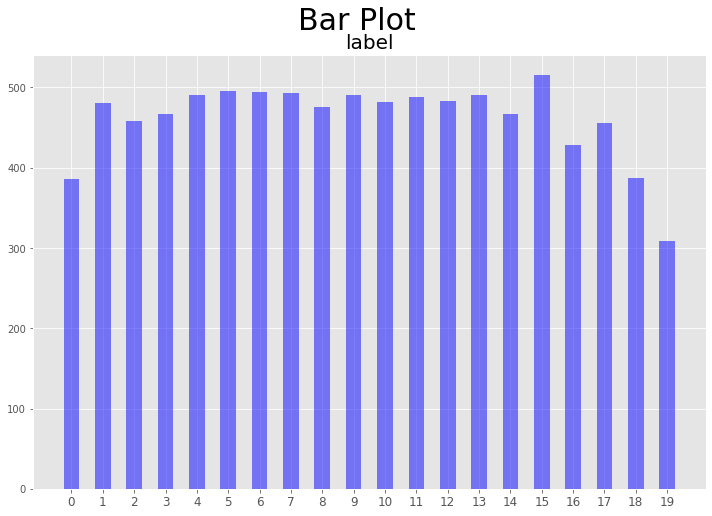

In [13]:
%matplotlib inline
plt.style.use("ggplot")

# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
feature = train['target']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정
plt.suptitle("Bar Plot", fontsize=30) # 부제목과 폰트 크기 설정

plt.title('label', fontsize=20) # 제목과 폰트 크기 설정
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

총 9233개의 데이터에서 20가지 라벨이 모두 300개가 넘고,

그중 19번 마지막 라벨이 가장 수가 적은 것을 확인했습니다.

# 뉴스 text 길이 확인

In [14]:
str_len_mean = np.mean(train['text'].str.len()) # 리뷰 길이의 평균값 계산
print('뉴스의 평균 길이 :',round(str_len_mean,0))

뉴스의 평균 길이 : 1020.0


뉴스 문자열의 평균 길이는 약 1020 입니다.

이번에는 뉴스들의 문자열 길이를 히스토그램으로 나타내보겠습니다.

In [15]:
# 데이터 필터링을 위한 마스크 설정
for i in range(0, 20):
  globals()['mask_{}'.format(i)] = (train.target == i)

# 전체 및 그룹 집합을 설정합니다.
df_train = train.text.copy() # 전체 train 데이터

for i in range(0, 20):
  globals()['df_{}'.format(i)] = train.loc[globals()['mask_{}'.format(i)],:].text # 20가지 라벨 각각에 해당하는 데이터를 df0~19로 할당

# 스무가지로 나뉜 집합을 리스트로 묶어줍니다.
compare = [df_0, df_1, df_2, df_3, df_4, df_5, 
           df_6, df_7, df_8, df_9, df_10, df_11,
           df_12, df_13, df_14, df_15, df_16, df_17,
           df_18, df_19]

라벨별로 스무가지로 나뉜 데이터프레임 중 0번째 라벨의 text 데이터를 살펴볼까요?

In [16]:
df_0

52      deleted stuff from andrew wrt which atheist my...
56      deletia in case anybody hadnt noticed frank an...
95      due to a discussion on this group some time ag...
113     no bobby stalin killed millions in the name of...
139     issued by khomeini it shouldnt be relevant to ...
                              ...                        
9116    wait a minute i thought you said that allah i ...
9138    i recall a discussion i had heard years ago it...
9149    i wonder how many atheists out there care to s...
9171    are you saying that their was a physical adam ...
9226    id like this too maybe you should post an answ...
Name: text, Length: 386, dtype: object

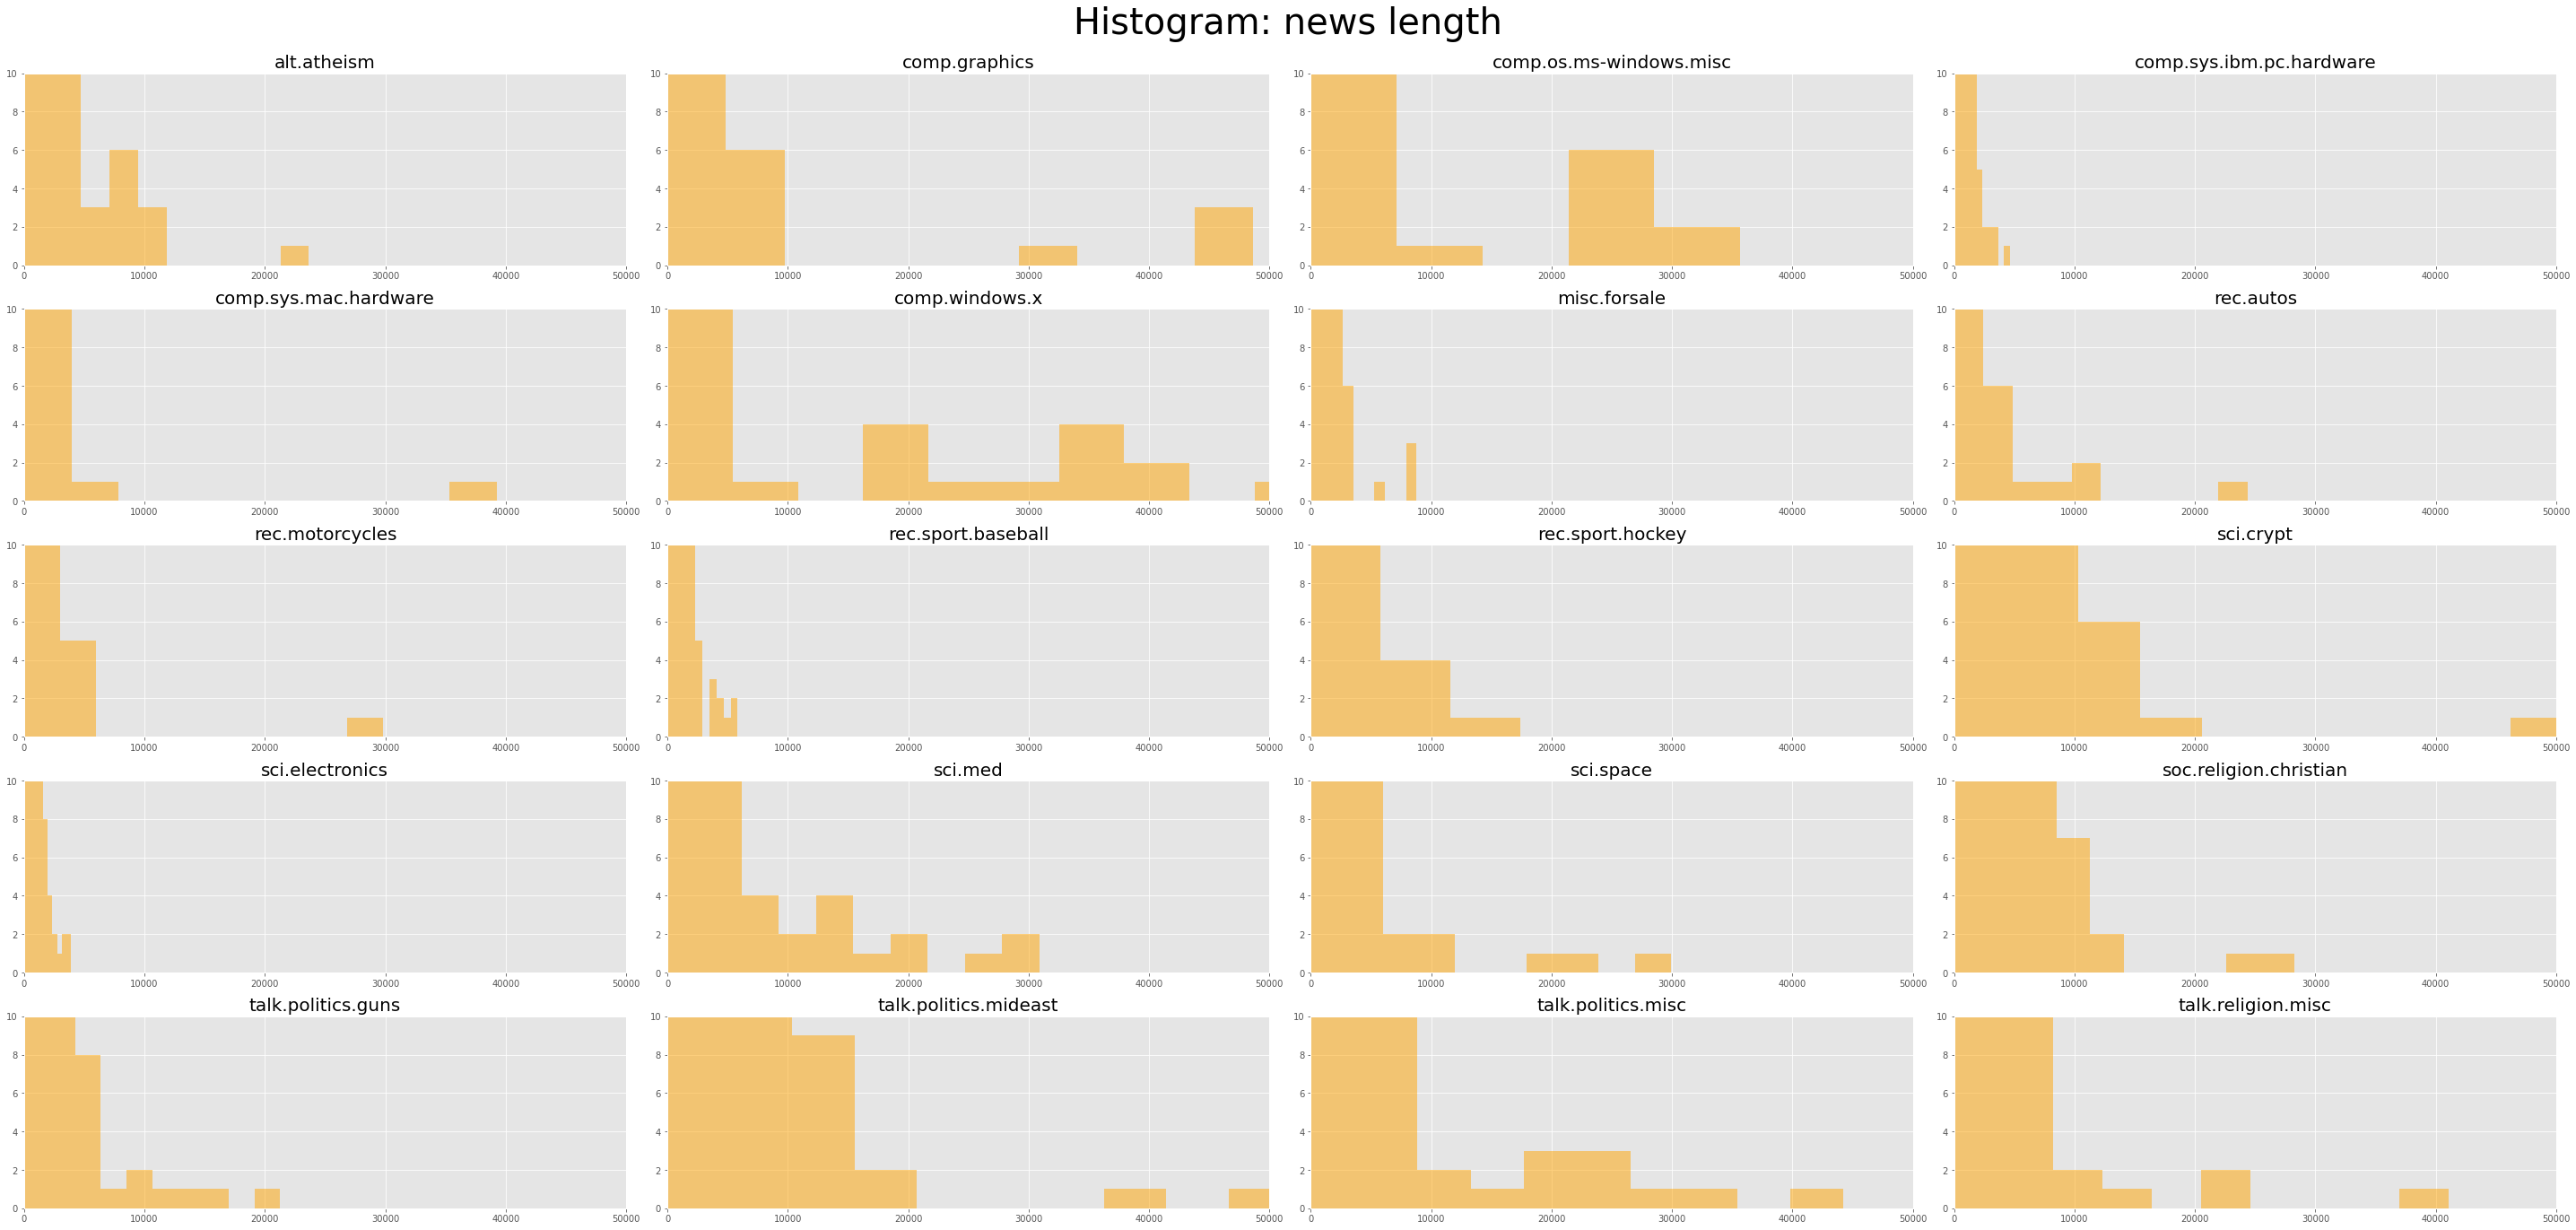

In [17]:
# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(40,20))
plt.suptitle("Histogram: news length", fontsize=40)
name = ['alt.atheism',
        'comp.graphics',
        'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware',
        'comp.sys.mac.hardware',
        'comp.windows.x',
        'misc.forsale',
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'rec.sport.hockey',
        'sci.crypt',
        'sci.electronics',
        'sci.med',
        'sci.space',
        'soc.religion.christian',
        'talk.politics.guns',
        'talk.politics.mideast',
        'talk.politics.misc',
        'talk.religion.misc'] # 제목으로 사용할 문자열 (라벨의 실제 이름)

for i in range(len(compare)):
    text = compare[i]
    string_len = [len(x) for x in text]    
    plt.subplot(5,4,i+1) # 행 개수/ 열 개수/ 해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([0, 50000, 0, 10])  #x축 시작, 끝 / y축 시작, 끝
    plt.hist(string_len, alpha=0.5, color='orange') # 히스토그램 생성, alpha: 그래프의 투명도 조절
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

대체적으로 문자열 길이가 10000 미만일 때의 빈도수가 많으며   
10000개 이상의 문자열 길이를 가진 데이터도 종종 보이는 것을 확인 할 수 있었습니다.   
데이터 길이의 분포는 각 라벨마다 상이하다는 인사이트를 도출하였습니다.   

# Word Cloud

## 워드 클라우드(word cloud)란?

태그 클라우드와 동의어인 워드 클라우드는 문서의 키워드 등을 직관적으로 파악할 수 있도록 하는 시각화 기법입니다.

예를 들어, 문서에 자주 언급된 단어일수록 크게 시각화하여 문서에서 등장하는 주요 단어들을 한눈에 파악할 수 있습니다.

이 기법은 문서 빅데이터 분석에서 자주 사용되곤 합니다.

## 워드 클라우드 패키지
워드 클라우드를 생성하기 위한 패키지를 불러오겠습니다.   
영어에 대한 전처리는 대표적으로 nltk를 사용합니다.   
이중에서 데이터 분석에 가장 큰 의미를 갖는 형태소인 명사만을 추출해 실제로 데이터 분석에 활용할 것 입니다.

In [18]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import nltk
import pickle
from nltk.corpus import stopwords
from os import path
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

데이터프레임으로 들어있는 뉴스 기사들을 하나의 문자열로 만들기 위한 메소드를 정의하겠습니다.

In [19]:
df_0[52]

'deleted stuff from andrew wrt which atheist myth is bill re tocounterfeit atheists hmmmm so were just cheap knockoffs of thetrue atheists religion demonstrates itself to be absurd constantly personally if someone asks im happy to point out how this is so man what is your pill wrt atheists if youre going to make suchcontentious statements back them up at least read news timeandtimeagain weve hashed out the beliefs various religous doctrines hold try debating reasonably with someone who makes a statement like more accurately oxymoric is the a term like reasonable atheistthen take a look at the responses weve given tammy seem prettyreasonable nay even polite to me accusations of myths aflyini saw your reference to according to in the original articlethen you do such an excellent job of spewing dogma that well theimplication was pretty clear if wrong in this casejeez a misunderstanding let it gomore statements to wrap this thing upif you had written your post with the same as care as the 

In [20]:
def df2str(df):
    
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

In [21]:
print(df2str(df_0[52]))

deleted stuff from andrew wrt which atheist myth is bill re tocounterfeit atheists hmmmm so were just cheap knockoffs of thetrue atheists religion demonstrates itself to be absurd constantly personally if someone asks im happy to point out how this is so man what is your pill wrt atheists if youre going to make suchcontentious statements back them up at least read news timeandtimeagain weve hashed out the beliefs various religous doctrines hold try debating reasonably with someone who makes a statement like more accurately oxymoric is the a term like reasonable atheistthen take a look at the responses weve given tammy seem prettyreasonable nay even polite to me accusations of myths aflyini saw your reference to according to in the original articlethen you do such an excellent job of spewing dogma that well theimplication was pretty clear if wrong in this casejeez a misunderstanding let it gomore statements to wrap this thing upif you had written your post with the same as care as the f

## 워드 토큰화

우선적으로 라벨이 0인 뉴스그룹의 텍스트를 분석하여  
라벨0 텍스트의 의미파악을 해보도록 하겠습니다.

워드클라우드를 만들기 위하여 텍스트를 토큰화 하겠습니다.
nltk의 word_tokenize 메소드를 이용하여 토큰화를 진행합니다.


In [22]:
word_tokens = nltk.word_tokenize(df2str(df_0))

In [23]:
#word_tokens

## 품사 분리 POS tagging

데이터 분석에 가장 큰 의미를 갖는 형태소인 명사만을 추출하기 위하여   
토큰화된 단어의 품사를 분리해보도록 하겠습니다.   
nltk의 pos_tag 메소드를 이용하여 품사분리를 진행합니다.

In [24]:
# pos_tag()의 입력값으로는 단어의 리스트가 들어가야 한다.
tokens_pos = nltk.pos_tag(word_tokens)

## 명사만 추출하기

명사는 NN을 포함하고 있으므로 NN이 들어있는 단어만을 추출해보도록 하겠습니다.

In [25]:
# 명사는 NN을 포함하고 있음을 알 수 있음
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)

In [26]:
#NN_words # 명사추출

## 품사 원형 찾기

워드클라우드 단어의 빈도수를 정확히 축정하기 위하여 단어의 원형형태로 통일해보도록 하겠습니다.

nltk에서 제공하는 WordNetLemmatizer() 메소드를 이용해 보겠습니다.

In [27]:
# 명사의 경우 보통 복수 -> 단수 형태로 변형
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in NN_words:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

## 불용어 처리

nltk에서 제공하는 불용어 기본 사전 이용하여 워드클라우드에 사용하지 않을 단어를 제거해 봅시다. 

In [28]:
stopwords_list = stopwords.words('english') #nltk에서 제공하는 불용어사전 이용
#print('stopwords: ', stopwords_list)
unique_NN_words = set(lemmatized_words)
final_NN_words = lemmatized_words

# 불용어 제거
for word in unique_NN_words:
    if word in stopwords_list:
        while word in final_NN_words: final_NN_words.remove(word)

In [29]:
final_NN_words[:10]

['stuff',
 'andrew',
 'wrt',
 'atheist',
 'myth',
 'bill',
 'tocounterfeit',
 'atheist',
 'knockoff',
 'atheist']

## 빈도분석

빈도수 상위 10개의 단어를 출력해보도록 하겠습니다.

In [30]:
from collections import Counter
c = Counter(final_NN_words)
k = 10

다음과 같이 10개의 리스트가 뽑힌 것을 확인할 수 있습니다.

In [31]:
c.most_common(k) # 빈도수 기준 상위 k개 단어 출력

[('god', 190),
 ('people', 176),
 ('argument', 122),
 ('time', 105),
 ('thing', 99),
 ('way', 97),
 ('book', 90),
 ('question', 89),
 ('something', 87),
 ('religion', 84)]

이를 그래프 시각화를 하여 빈도수 기준으로 보기 좋게 표현해 봅시다.

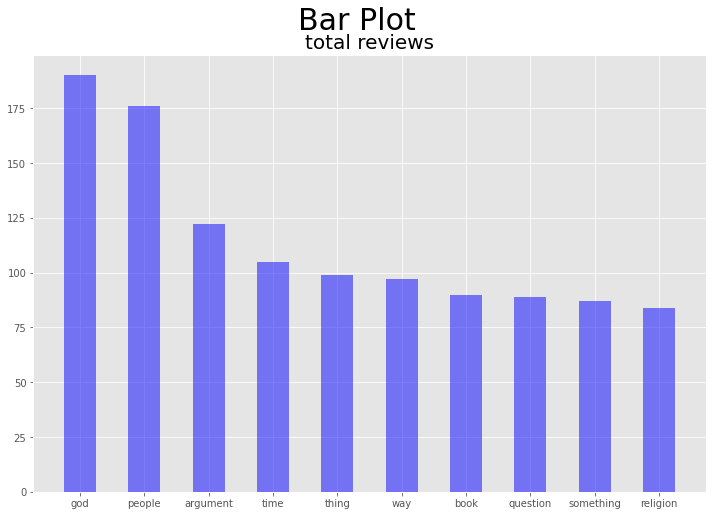

In [32]:
top_10 = c.most_common(k) # 추출한 명사 중 상위 10개
keys = [top_10[i][0] for i in range(len(top_10))]
values = [top_10[i][1] for i in range(len(top_10))]

plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=30)
plt.title('total reviews', fontsize=20)
plt.bar(keys, values, width=0.5, color='b', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 워드클라우드

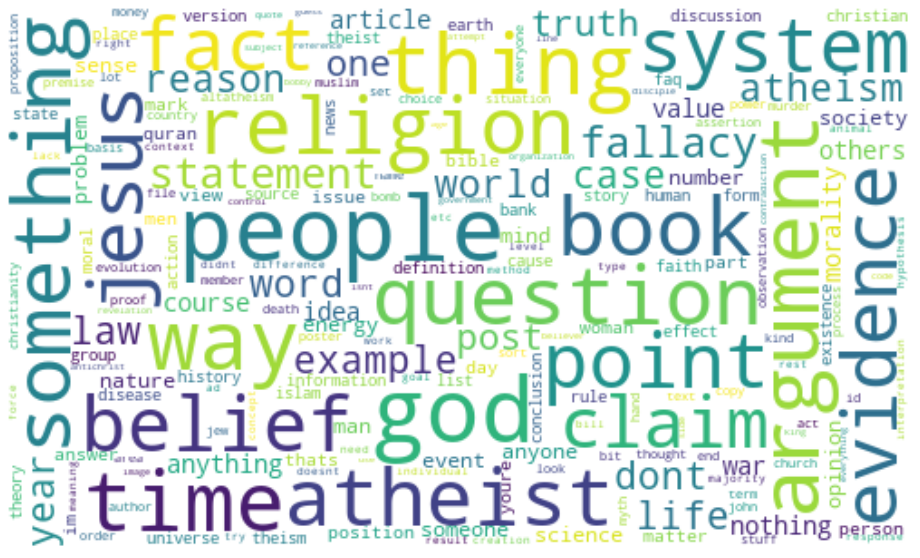

In [33]:
noun_text = ''
for word in final_NN_words:
    noun_text = noun_text +' '+word

wordcloud = WordCloud(max_font_size=50, #가장 큰 폰트 크기 제한
                      width=500, #너비
                      height=300, #높이
                      background_color='white', #배경 색상
                      relative_scaling=.2 #상대적인 크기
                      ).generate(noun_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

0번 뉴스 그룹 'alt.atheism'의 키워드가 다음과 같이 나와있음을 확인할 수 있습니다.

'god', 'people', 'argument', 'time' 등 단어가 유즈넷 뉴스의 atheism (무신론) 그룹에서 많이 언급되었다는 사실을 알 수 있습니다.

이와같은 방식으로 여러분들께서 직접 다른 뉴스 그룹도 시각화 해보는건 어떨까요?

# 다른 뉴스 그룹 WordCloud 시각화

In [34]:
def vis_2_wc(df):
  word_tokens = nltk.word_tokenize(df2str(df)) # tokenize
  tokens_pos = nltk.pos_tag(word_tokens) # pos tagging
  NN_words = []
  for word, pos in tokens_pos: # find nouns
    if 'NN' in pos:
        NN_words.append(word)
  wlem = nltk.WordNetLemmatizer()
  lemmatized_words = []
  for word in NN_words: # make to originals, plrs to singular
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)
  stopwords_list = stopwords.words('english') #nltk에서 제공하는 불용어사전 이용
  #print('stopwords: ', stopwords_list)
  unique_NN_words = set(lemmatized_words)
  final_NN_words = lemmatized_words

  # 불용어 제거
  for word in unique_NN_words:
      if word in stopwords_list:
          while word in final_NN_words: final_NN_words.remove(word)
  
  noun_text = ''
  for word in final_NN_words:
    noun_text = noun_text +' '+word

  wordcloud = WordCloud(max_font_size=50, #가장 큰 폰트 크기 제한
                      width=500, #너비
                      height=300, #높이
                      background_color='white', #배경 색상
                      relative_scaling=.2 #상대적인 크기
                      ).generate(noun_text)

  plt.figure(figsize=(20,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [37]:
name =  ['alt.atheism',
           'comp.graphics',
        'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware',
        'comp.sys.mac.hardware',
        'comp.windows.x',
        'misc.forsale',
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'rec.sport.hockey',
        'sci.crypt',
        'sci.electronics',
        'sci.med',
        'sci.space',
        'soc.religion.christian',
        'talk.politics.guns',
        'talk.politics.mideast',
        'talk.politics.misc',
        'talk.religion.misc']

In [43]:
compare[1]

6       hi i need to know if there is a color graphics...
35      i am a macuser when it comes to graphics thats...
43      a developable surface is st you can lay it or ...
75      by grey level images you mean items of bit ima...
88          what aboutqrttoppm < filedis ppmtotga filetga
                              ...                        
9160    there was a very useful article in one of the ...
9170    snipthe do is not a snipthe do box is based on...
9174    lightwaved maillist what is lightwave lightwav...
9182    well is binary and who would forget that its t...
9205    if this question is covered elsewhere i apolog...
Name: text, Length: 480, dtype: object

In [44]:

for i in compare[1:]:
  vis_2_wc(i)



Output hidden; open in https://colab.research.google.com to view.